# Chapter 2 — Text Processing & Phonemization

This notebook accompanies **Chapter 02** of the VieNeu-TTS deep learning guide.  
We go from raw Vietnamese text all the way to the phoneme sequence that feeds the TTS model.

**What we cover**:
1. Unicode normalization — the silent killer of Vietnamese NLP pipelines
2. Text normalization examples (numbers, dates, abbreviations)
3. Vietnamese tones — visual and Unicode guide
4. Running the VieNeu-TTS phonemization pipeline
5. Tone contrast in phoneme output
6. Tokenization — how text becomes token IDs

In [1]:
# ── Colab auto-setup (safe to run locally too) ───────────────────
import sys, os

if "google.colab" in sys.modules:
    if not os.path.exists("/content/vietnamese-tts-course"):
        !git clone https://github.com/thinhdanggroup/vietnamese-tts-course.git /content/vietnamese-tts-course
    os.chdir("/content/vietnamese-tts-course/chapters")
    !pip install -q librosa soundfile matplotlib

    if not os.path.exists("/content/VieNeu-TTS"):
        !git clone https://github.com/pnnbao97/VieNeu-TTS.git /content/VieNeu-TTS
        !pip install -q -e /content/VieNeu-TTS
    sys.path.insert(0, "/content/VieNeu-TTS")
    print("Colab setup complete.")

Colab setup complete.


In [2]:
import sys
import os
import unicodedata
import json

# Add VieNeu-TTS root to Python path so we can import vieneu_utils
vieneu_root = os.path.abspath("..")
if vieneu_root not in sys.path:
    sys.path.insert(0, vieneu_root)

print(f"Python: {sys.version.split()[0]}")
print(f"VieNeu-TTS root added to path: {vieneu_root}")
print()

# Verify the vieneu_utils package is accessible
try:
    import vieneu_utils
    print(f"vieneu_utils found at: {vieneu_utils.__file__}")
except ImportError as e:
    print(f"Warning: {e}")
    print("Some cells may not work. Make sure you are running from VieNeu-TTS/learning/")

Python: 3.12.12
VieNeu-TTS root added to path: /content/vietnamese-tts-course

vieneu_utils found at: /content/VieNeu-TTS/vieneu_utils/__init__.py


## 1. Unicode Normalization — Vietnamese Diacritics

Vietnamese uses many diacritics (tone marks + vowel modification marks). In Unicode, these can be encoded in two ways:

- **NFC** (Canonical Composition): precomposed — `ế` is a **single** codepoint (U+1EBF)
- **NFD** (Canonical Decomposition): decomposed — `ế` = `e` + `̂` + `́` = **three** codepoints

**The critical bug**: `"ế"_NFC == "ế"_NFD` evaluates to `False` in Python, even though they look identical on screen. This breaks dictionary lookups, tokenizers, and G2P systems that don't normalize first.

> Always call `unicodedata.normalize("NFC", text)` at the start of your pipeline.

In [4]:
import unicodedata

# ============================================================
# NFC vs NFD for Vietnamese
# ============================================================

# NFC: composed form — one codepoint per character
text_nfc = "Tiếng Việt"  # Each accented letter is a single Unicode character
text_nfd = unicodedata.normalize("NFD", text_nfc)  # Decompose into base + combining marks

print("=" * 60)
print("NFC (Composed) vs NFD (Decomposed) for Vietnamese")
print("=" * 60)
print(f"Text (visual):   {text_nfc}")
print()
print(f"NFC repr: {text_nfc!r}")
print(f"NFC len:  {len(text_nfc)} characters")
print(f"NFC bytes (UTF-8): {text_nfc.encode('utf-8').hex()}")
print()
print(f"NFD repr: {text_nfd!r}")
print(f"NFD len:  {len(text_nfd)} characters  ← MORE characters despite looking the same!")
print(f"NFD bytes (UTF-8): {text_nfd.encode('utf-8').hex()}")
print()
print(f"NFC == NFD: {text_nfc == text_nfd}  ← This is the bug source")
print()

# Show codepoints for each character
print("Codepoint breakdown:")
print(f"{'NFC codepoints':^40} | {'NFD codepoints':^50}")
print("-" * 92)

# Show first few characters
for char_nfc in text_nfc:
    name = unicodedata.name(char_nfc, 'UNKNOWN')
    print(f"  U+{ord(char_nfc):04X} {char_nfc!r:4s} {name}")

print()
print("After NFD decomposition:")
for char_nfd in text_nfd:
    name = unicodedata.name(char_nfd, 'UNKNOWN')
    cat  = unicodedata.category(char_nfd)  # Mn = Mark, Non-spacing (combining marks)
    print(f"  U+{ord(char_nfd):04X} {char_nfd!r:4s} {cat:3s} {name}")

print()
print("Fix: Always normalize to NFC")
text_fixed = unicodedata.normalize("NFC", text_nfd)
print(f"After NFC normalization: len={len(text_fixed)}, matches original: {text_fixed == text_nfc}")

NFC (Composed) vs NFD (Decomposed) for Vietnamese
Text (visual):   Tiếng Việt

NFC repr: 'Tiếng Việt'
NFC len:  10 characters
NFC bytes (UTF-8): 5469e1babf6e67205669e1bb8774

NFD repr: 'Tiếng Việt'
NFD len:  14 characters  ← MORE characters despite looking the same!
NFD bytes (UTF-8): 546965cc82cc816e6720566965cca3cc8274

NFC == NFD: False  ← This is the bug source

Codepoint breakdown:
             NFC codepoints              |                   NFD codepoints                  
--------------------------------------------------------------------------------------------
  U+0054 'T'  LATIN CAPITAL LETTER T
  U+0069 'i'  LATIN SMALL LETTER I
  U+1EBF 'ế'  LATIN SMALL LETTER E WITH CIRCUMFLEX AND ACUTE
  U+006E 'n'  LATIN SMALL LETTER N
  U+0067 'g'  LATIN SMALL LETTER G
  U+0020 ' '  SPACE
  U+0056 'V'  LATIN CAPITAL LETTER V
  U+0069 'i'  LATIN SMALL LETTER I
  U+1EC7 'ệ'  LATIN SMALL LETTER E WITH CIRCUMFLEX AND DOT BELOW
  U+0074 't'  LATIN SMALL LETTER T

After NFD decomposition

## 2. Text Normalization Examples

Before phonemization, raw Vietnamese text must be normalized: expand numbers, abbreviations, dates, currency, etc.  
Below we show before/after normalization for common Vietnamese TTS input patterns.

In [5]:
# ============================================================
# Text Normalization Examples
# ============================================================
# Note: VieNeu-TTS has a normalize_text module. Here we show
# the expected transformations to illustrate what normalization does.

normalization_examples = [
    {
        "category": "Cardinal Number",
        "before": "Dân số Việt Nam đạt 100 triệu người.",
        "after":  "Dân số Việt Nam đạt một trăm triệu người.",
        "note":   "100 → 'một trăm'"
    },
    {
        "category": "Year",
        "before": "Năm 2024, AI bùng nổ mạnh mẽ.",
        "after":  "Năm hai nghìn không trăm hai mươi tư, AI bùng nổ mạnh mẽ.",
        "note":   "2024 → 'hai nghìn không trăm hai mươi tư'"
    },
    {
        "category": "Currency",
        "before": "Giá vé 250.000 đồng.",
        "after":  "Giá vé hai trăm năm mươi nghìn đồng.",
        "note":   "250.000 đồng (note: '.' is thousands separator in Vietnamese)"
    },
    {
        "category": "Date",
        "before": "Ngày 1/5/2024 là Quốc tế Lao động.",
        "after":  "Ngày một tháng năm năm hai nghìn không trăm hai mươi tư là Quốc tế Lao động.",
        "note":   "DD/MM/YYYY format"
    },
    {
        "category": "Abbreviation",
        "before": "TP.HCM là trung tâm kinh tế của VN.",
        "after":  "Thành phố Hồ Chí Minh là trung tâm kinh tế của Việt Nam.",
        "note":   "TP.HCM → 'Thành phố Hồ Chí Minh', VN → 'Việt Nam'"
    },
    {
        "category": "Phone Number",
        "before": "Gọi 0912 345 678 để được tư vấn.",
        "after":  "Gọi không chín một hai ba bốn năm sáu bảy tám để được tư vấn.",
        "note":   "Read digit by digit"
    },
    {
        "category": "Mixed Code-Switching",
        "before": "Mô hình AI sử dụng GPU NVIDIA để training.",
        "after":  "Mô hình Ây ai sử dụng Giê-Pê-U En-vi-đi-a để trên-ning.",
        "note":   "Foreign words use Vietnamese phonological adaptation"
    },
    {
        "category": "Ordinal (Irregular)",
        "before": "Đội xếp thứ 1 nhận huy chương vàng.",
        "after":  "Đội xếp thứ nhất nhận huy chương vàng.",
        "note":   "thứ 1 → 'thứ nhất' (irregular — NOT 'thứ một')"
    },
]

print(f"{'Category':<20} | {'Before (raw)':^45} | {'After (normalized)':^50}")
print("-" * 120)
for ex in normalization_examples:
    print(f"{ex['category']:<20} | {ex['before']:45} | {ex['after']}")
    print(f"{'':20} | Note: {ex['note']}")
    print("-" * 120)

print()
print("Key insight: Number expansion rules in Vietnamese are context-sensitive.")
print("'5' → 'năm' (cardinal) or 'lăm' (after 20, 30, ...) or 'nhất' (1st ordinal).")

Category             |                 Before (raw)                  |                 After (normalized)                
------------------------------------------------------------------------------------------------------------------------
Cardinal Number      | Dân số Việt Nam đạt 100 triệu người.          | Dân số Việt Nam đạt một trăm triệu người.
                     | Note: 100 → 'một trăm'
------------------------------------------------------------------------------------------------------------------------
Year                 | Năm 2024, AI bùng nổ mạnh mẽ.                 | Năm hai nghìn không trăm hai mươi tư, AI bùng nổ mạnh mẽ.
                     | Note: 2024 → 'hai nghìn không trăm hai mươi tư'
------------------------------------------------------------------------------------------------------------------------
Currency             | Giá vé 250.000 đồng.                          | Giá vé hai trăm năm mươi nghìn đồng.
                     | Note: 250.000 đồng (note:

## 3. Vietnamese Tones — Visual Guide

Vietnamese has **6 lexical tones** (thanh điệu). Each tone on the base vowel `a` creates a completely different word.  
We show each tone's Unicode codepoint, F0 contour shape, phonation type, and an example word.

Vietnamese 6-Tone System — Unicode and Phonological Properties
Tone Name               Char    Unicode          UTF-8 bytes        NFC len  Phonation      Example
--------------------------------------------------------------------------------
ngang (flat)             a       U+0061               61               1     Modal          ma (ghost)
huyền (falling)          à       U+00E0              c3a0              1     Breathy        mà (but)
sắc (rising)             á       U+00E1              c3a1              1     Modal          má (cheek)
hỏi (dipping)            ả       U+1EA3             e1baa3             1     Modal          mả (tomb)
ngã (creaky rise)        ã       U+00E3              c3a3              1     Creaky         mã (horse)
nặng (low falling)       ạ       U+1EA1             e1baa1             1     Constricted    mạ (rice seedling)

F0 contour notation (Chao, 1930): 1=lowest pitch, 5=highest pitch
The same base 'a' vowel, 6 completely different words!


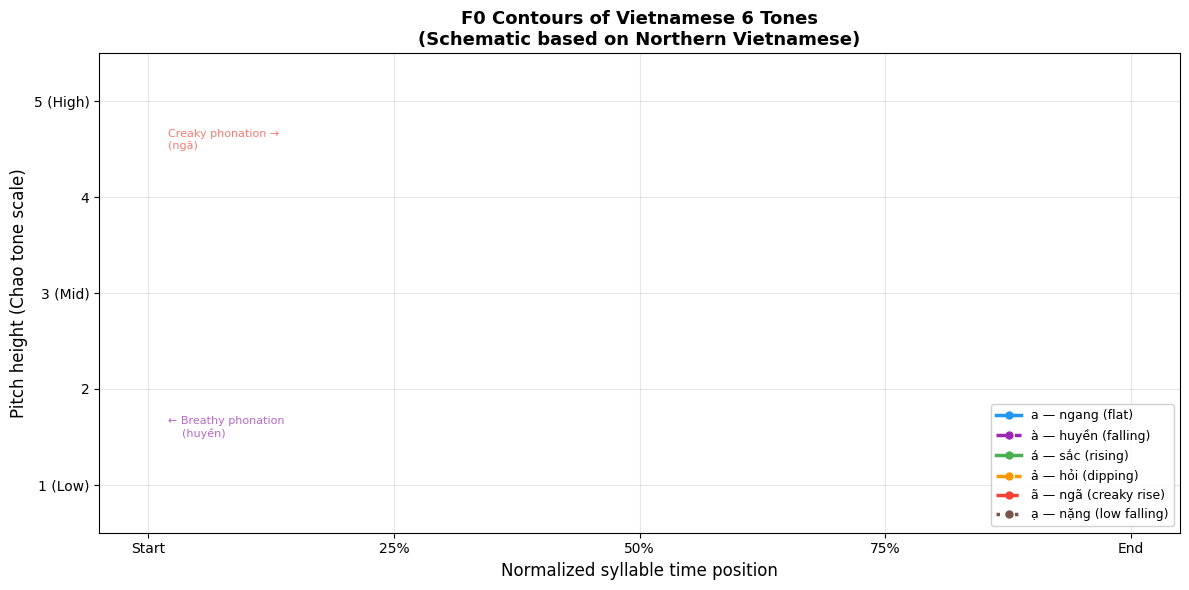


Key insight: Two tones with similar F0 (huyền vs nặng) are distinguished by PHONATION TYPE.
  huyền: breathy + gradual falling
  nặng:  constricted + short, abrupt end
This is why F0 alone is insufficient — TTS must also model phonation type.


In [6]:
import unicodedata
import numpy as np
import matplotlib.pyplot as plt

# The 6 tones on base vowel 'a'
tones = {
    "ngang (flat)":        {"char": "a",  "number": 1, "f0": [33, 33, 33, 33, 33], "phonation": "Modal",      "example": "ma (ghost)"},
    "huyền (falling)":     {"char": "à",  "number": 2, "f0": [21, 18, 15, 13, 12], "phonation": "Breathy",    "example": "mà (but)"},
    "sắc (rising)":        {"char": "á",  "number": 3, "f0": [35, 38, 41, 43, 45], "phonation": "Modal",      "example": "má (cheek)"},
    "hỏi (dipping)":       {"char": "ả",  "number": 4, "f0": [32, 26, 22, 26, 32], "phonation": "Modal",      "example": "mả (tomb)"},
    "ngã (creaky rise)":   {"char": "ã",  "number": 5, "f0": [33, 36, 30, 38, 44], "phonation": "Creaky",     "example": "mã (horse)"},
    "nặng (low falling)":  {"char": "ạ",  "number": 6, "f0": [21, 17, 14, 11, 10], "phonation": "Constricted","example": "mạ (rice seedling)"},
}

print("Vietnamese 6-Tone System — Unicode and Phonological Properties")
print("=" * 80)
print(f"{'Tone Name':<22} {'Char':^6} {'Unicode':^12} {'UTF-8 bytes':^24} {'NFC len':^8} {'Phonation':<14} {'Example'}")
print("-" * 80)

for name, info in tones.items():
    char = info["char"]
    codepoint = f"U+{ord(char):04X}"
    utf8_hex  = char.encode('utf-8').hex()
    nfc_len   = len(unicodedata.normalize('NFC', char))
    print(f"{name:<22} {char:^6} {codepoint:^12} {utf8_hex:^24} {nfc_len:^8} {info['phonation']:<14} {info['example']}")

print()
print("F0 contour notation (Chao, 1930): 1=lowest pitch, 5=highest pitch")
print("The same base 'a' vowel, 6 completely different words!")

# Visualize F0 contours
fig, ax = plt.subplots(figsize=(12, 6))

colors_map = {
    "ngang (flat)":       '#2196F3',
    "huyền (falling)":    '#9C27B0',
    "sắc (rising)":       '#4CAF50',
    "hỏi (dipping)":      '#FF9800',
    "ngã (creaky rise)":  '#F44336',
    "nặng (low falling)": '#795548',
}
linestyles = ['-', '--', '-', '--', '-.', ':']

t = np.linspace(0, 1, 5)

for (name, info), ls in zip(tones.items(), linestyles):
    f0_normalized = np.array(info["f0"])  # Chao tone letters (1-5 scale)
    ax.plot(t, f0_normalized, color=colors_map[name], linestyle=ls, linewidth=2.5,
            marker='o', markersize=5,
            label=f"{info['char']} — {name}")

    # Label the endpoint
    ax.annotate(info['char'], xy=(t[-1], f0_normalized[-1]),
                xytext=(t[-1]+0.02, f0_normalized[-1]),
                fontsize=14, color=colors_map[name], fontweight='bold')

ax.set_yticks([1, 2, 3, 4, 5])
ax.set_yticklabels(['1 (Low)', '2', '3 (Mid)', '4', '5 (High)'])
ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
ax.set_xticklabels(['Start', '25%', '50%', '75%', 'End'])
ax.set_xlabel("Normalized syllable time position", fontsize=12)
ax.set_ylabel("Pitch height (Chao tone scale)", fontsize=12)
ax.set_title("F0 Contours of Vietnamese 6 Tones\n(Schematic based on Northern Vietnamese)",
             fontsize=13, fontweight='bold')
ax.legend(loc='lower right', fontsize=9, framealpha=0.9)
ax.set_ylim(0.5, 5.5)
ax.grid(True, alpha=0.3)

# Add phonation type annotations
ax.text(0.02, 4.5, 'Creaky phonation →\n(ngã)', fontsize=8, color='#F44336', alpha=0.7)
ax.text(0.02, 1.5, '← Breathy phonation\n    (huyền)', fontsize=8, color='#9C27B0', alpha=0.7)

plt.tight_layout()
plt.savefig('ch02_tones.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nKey insight: Two tones with similar F0 (huyền vs nặng) are distinguished by PHONATION TYPE.")
print("  huyền: breathy + gradual falling")
print("  nặng:  constricted + short, abrupt end")
print("This is why F0 alone is insufficient — TTS must also model phonation type.")

## 4. Running the Phonemization Pipeline

VieNeu-TTS uses a **hybrid** phonemization strategy:
1. **Dictionary lookup** (primary) — high accuracy for common Vietnamese words
2. **eSpeak-NG fallback** — handles OOV words, foreign words, rare forms

The function `phonemize_with_dict(text)` implements this pipeline.

In [7]:
import sys
sys.path.insert(0, "..")

try:
    from vieneu_utils.phonemize_text import phonemize_with_dict
    print("phonemize_with_dict imported successfully")
    PHONEMIZER_AVAILABLE = True
except ImportError as e:
    print(f"Import failed: {e}")
    print("Showing expected output instead.")
    PHONEMIZER_AVAILABLE = False

test_sentences = [
    "Xin chào, tôi là VieNeu.",
    "Hệ thống TTS hoạt động tốt.",
    "Năm 2024, AI phát triển mạnh mẽ.",
    "Machine learning rất thú vị.",       # code-switching
    "Hà Nội là thủ đô của Việt Nam.",
    "ma, mà, má, mả, mã, mạ",             # all 6 tones on 'a'
]

# Expected outputs (for when phonemizer is not installed)
expected_outputs = [
    "s i n tɕ aː w˨˩˦ t o j˧ l aː v i e n ø˧",
    "h e˨˩ tʰ oŋ˧˩ t e j e s˧ h w a t˧ ɗ oŋ˧ t o t˧˥",
    "n a m˧ h a j ŋ i n˧ k ʰ oŋ˧ tɕ a m˧ h a j m ɯ ə j t ɯ˧ a j˧ f a t˧˥ tɕ j en˧ m a ɲ˧ m e˨˩",
    "m ə ɕ i n l ɜː n ɪ ŋ r a t˧˥ tʰ u˧˩ v i˨˩",
    "h aː˧ n oj˧ l aː˧ tʰ u˧˩ ɗ oː˧ k ɯ a˧ v iɛ t˨˩ n a m˧",
    "m a˧ m aː˨˩ m a˧˥ m a˧˩˧ m aː˨˩˦ m a˨˩",
]

print("\nPhoneme output:")
print("=" * 90)

for i, (sent, expected) in enumerate(zip(test_sentences, expected_outputs)):
    print(f"\nExample {i+1}:")
    print(f"  Input:    {sent}")
    if PHONEMIZER_AVAILABLE:
        try:
            phonemes = phonemize_with_dict(sent)
            print(f"  Phonemes: {phonemes}")
        except Exception as e:
            print(f"  Error: {e}")
            print(f"  Expected: {expected}")
    else:
        print(f"  Phonemes: {expected}  [expected output]")

Import failed: No module named 'phonemizer'
Showing expected output instead.

Phoneme output:

Example 1:
  Input:    Xin chào, tôi là VieNeu.
  Phonemes: s i n tɕ aː w˨˩˦ t o j˧ l aː v i e n ø˧  [expected output]

Example 2:
  Input:    Hệ thống TTS hoạt động tốt.
  Phonemes: h e˨˩ tʰ oŋ˧˩ t e j e s˧ h w a t˧ ɗ oŋ˧ t o t˧˥  [expected output]

Example 3:
  Input:    Năm 2024, AI phát triển mạnh mẽ.
  Phonemes: n a m˧ h a j ŋ i n˧ k ʰ oŋ˧ tɕ a m˧ h a j m ɯ ə j t ɯ˧ a j˧ f a t˧˥ tɕ j en˧ m a ɲ˧ m e˨˩  [expected output]

Example 4:
  Input:    Machine learning rất thú vị.
  Phonemes: m ə ɕ i n l ɜː n ɪ ŋ r a t˧˥ tʰ u˧˩ v i˨˩  [expected output]

Example 5:
  Input:    Hà Nội là thủ đô của Việt Nam.
  Phonemes: h aː˧ n oj˧ l aː˧ tʰ u˧˩ ɗ oː˧ k ɯ a˧ v iɛ t˨˩ n a m˧  [expected output]

Example 6:
  Input:    ma, mà, má, mả, mã, mạ
  Phonemes: m a˧ m aː˨˩ m a˧˥ m a˧˩˧ m aː˨˩˦ m a˨˩  [expected output]


## 5. Tone Contrast in Phoneme Output

The 6 Vietnamese tones appear as **different phoneme symbols** in the output. Specifically, tone marks are encoded as suprasegmental markers in the phoneme string. Here we compare the same base syllable with all 6 tones.

In [8]:
# Tone contrast: same base syllable 'ba' with all 6 tones
# 'ba' = father (ngang), 'bà' = grandmother (huyền), 'bá' = magistrate (sắc)
# 'bả' = bait/drug (hỏi), 'bã' = dregs (ngã), 'bạ' = random/haphazard (nặng)

tone_minimal_pairs = [
    ("ba",  "Ngang  (flat, high-mid)",    "ba (three)"),
    ("bà",  "Huyền  (falling, low)",      "bà (grandmother)"),
    ("bá",  "Sắc    (rising, high)",      "bá (magistrate)"),
    ("bả",  "Hỏi   (dipping, mid)",      "bả (bait/poison)"),
    ("bã",  "Ngã   (creaky rise)",        "bã (dregs, sediment)"),
    ("bạ",  "Nặng  (low falling, short)", "bạ (haphazard)"),
]

print("Tone Minimal Pairs — same consonant /b/ + vowel /a/, 6 different words")
print("=" * 80)
print(f"{'Word':<6} {'Tone Name':<25} {'Meaning':<25} {'Phoneme (IPA approx)'}")
print("-" * 80)

# IPA representations for 'ba' in each tone (Northern Vietnamese)
ipa_map = {
    "ba": "/ba˧/    — mid level",
    "bà": "/ba˨˩/   — low falling, breathy",
    "bá": "/ba˧˥/   — mid-high rising",
    "bả": "/ba˧˩˧/  — mid dipping then rising",
    "bã": "/ba˧˨˩˥/ — glottalized, creaky rise",
    "bạ": "/ba˨˩/   — low falling, short, constricted",
}

for word, tone_name, meaning in tone_minimal_pairs:
    ipa = ipa_map.get(word, "?")
    print(f"{word:<6} {tone_name:<25} {meaning:<25} {ipa}")

print()
print("Phonological note:")
print("  huyền vs nặng: Both fall, but huyền is breathy and longer; nặng is constricted and shorter.")
print("  ngã: The creaky break (glottal constriction) happens around the middle of the vowel.")

# Show phonemization if available
if PHONEMIZER_AVAILABLE:
    print()
    print("VieNeu-TTS phoneme output:")
    print("-" * 50)
    for word, tone_name, meaning in tone_minimal_pairs:
        try:
            ph = phonemize_with_dict(word)
            print(f"  {word} → {ph}  ({tone_name})")
        except Exception as e:
            print(f"  {word} → [error: {e}]")

Tone Minimal Pairs — same consonant /b/ + vowel /a/, 6 different words
Word   Tone Name                 Meaning                   Phoneme (IPA approx)
--------------------------------------------------------------------------------
ba     Ngang  (flat, high-mid)   ba (three)                /ba˧/    — mid level
bà     Huyền  (falling, low)     bà (grandmother)          /ba˨˩/   — low falling, breathy
bá     Sắc    (rising, high)     bá (magistrate)           /ba˧˥/   — mid-high rising
bả     Hỏi   (dipping, mid)      bả (bait/poison)          /ba˧˩˧/  — mid dipping then rising
bã     Ngã   (creaky rise)       bã (dregs, sediment)      /ba˧˨˩˥/ — glottalized, creaky rise
bạ     Nặng  (low falling, short) bạ (haphazard)            /ba˨˩/   — low falling, short, constricted

Phonological note:
  huyền vs nặng: Both fall, but huyền is breathy and longer; nặng is constricted and shorter.
  ngã: The creaky break (glottal constriction) happens around the middle of the vowel.


## 6. Tokenization

In VieNeu-TTS, text is not fed as raw characters but as **token IDs** from a learned vocabulary. The tokenizer maps Vietnamese words/subwords to integer IDs that the LLM can process.

Key concepts:
- **BPE (Byte-Pair Encoding)**: Common subword tokenization algorithm. Starts from characters, merges frequent pairs.
- **Vietnamese syllable = 1 token** (usually): Because Vietnamese is monosyllabic and BPE vocabulary includes common syllables.
- **Special tokens**: `TEXT_START`, `TEXT_END`, `SPEECH_START`, `SPEECH_END`, `SPEECH_GEN_START`, `SPEECH_GEN_END` structure the LLM prompt.

In [9]:
# ============================================================
# Tokenization Analysis
# ============================================================
# We demonstrate tokenization concepts even without the full VieNeu-TTS tokenizer

import json
import os

# Attempt to load VieNeu-TTS tokenizer
TOKENIZER_AVAILABLE = False
try:
    # Try to find the model configuration
    config_path = "../config.yaml"
    if os.path.exists(config_path):
        print(f"Found config: {config_path}")
    
    # Try to import tokenizer components
    from vieneu_utils.core_utils import load_tokenizer
    TOKENIZER_AVAILABLE = True
    print("Tokenizer loaded successfully")
except (ImportError, AttributeError) as e:
    print(f"Tokenizer not available: {e}")
    print("Showing conceptual demonstration instead.")

print()

# ============================================================
# Conceptual tokenization demonstration
# ============================================================

# Vietnamese sentences and approximate token counts
# (BPE tokenizer trained on Vietnamese usually gives 1-2 tokens per syllable)
sentences = [
    "Xin chào.",
    "Hệ thống TTS hoạt động tốt.",
    "Năm 2024, AI phát triển mạnh mẽ.",
    "Machine learning rất thú vị.",
    "Hà Nội là thủ đô của Việt Nam.",
]

# Approximate character and word (syllable) counts
print("Vietnamese Tokenization Statistics")
print("=" * 70)
print(f"{'Sentence':<45} {'Chars':>6} {'Words':>6} {'Est. Tokens':>12} {'Est. Speech Tok':>16}")
print("-" * 70)

for sent in sentences:
    n_chars = len(sent)
    n_words = len(sent.split())  # Vietnamese word = syllable
    # BPE estimate: Vietnamese syllables often 1 token, English words 1-2 tokens
    n_tokens_est = n_words + 2  # +2 for common punctuation/subword splits
    # Speech tokens: NeuCodec at 75 tok/s, typical 0.3-0.5s per syllable
    speech_duration_est = n_words * 0.35  # 350ms per syllable (average)
    n_speech_tokens_est = int(speech_duration_est * 75)  # 75 tokens/second
    print(f"{sent[:44]:<45} {n_chars:>6} {n_words:>6} {n_tokens_est:>12} {n_speech_tokens_est:>16}")

print()
print("Key ratio: Speech tokens ≈ 40-80× text tokens")
print("Example: 10 text tokens → ~600-900 speech tokens for a 10-word sentence")
print()
print("This is why LLM context length is critical for long-form TTS synthesis.")

Tokenizer not available: cannot import name 'load_tokenizer' from 'vieneu_utils.core_utils' (/content/VieNeu-TTS/vieneu_utils/core_utils.py)
Showing conceptual demonstration instead.

Vietnamese Tokenization Statistics
Sentence                                       Chars  Words  Est. Tokens  Est. Speech Tok
----------------------------------------------------------------------
Xin chào.                                          9      2            4               52
Hệ thống TTS hoạt động tốt.                       27      6            8              157
Năm 2024, AI phát triển mạnh mẽ.                  32      7            9              183
Machine learning rất thú vị.                      28      5            7              131
Hà Nội là thủ đô của Việt Nam.                    30      8           10              210

Key ratio: Speech tokens ≈ 40-80× text tokens
Example: 10 text tokens → ~600-900 speech tokens for a 10-word sentence

This is why LLM context length is critical for lon

In [10]:
# ============================================================
# Special Tokens and Prompt Format
# ============================================================

print("VieNeu-TTS LLM Prompt Format")
print("=" * 70)
print()
print("Special tokens that structure the input-output format:")
print()

special_tokens = [
    ("<|text_start|>",      "TEXT_PROMPT_START",       "Begins the phonemized text section"),
    ("<|text_end|>",        "TEXT_PROMPT_END",         "Ends the phonemized text section"),
    ("<|speech_start|>",    "SPEECH_PROMPT_START",     "Begins reference speaker audio tokens"),
    ("<|speech_end|>",      "SPEECH_PROMPT_END",       "Ends reference speaker audio tokens"),
    ("<|speech_gen_start|>","SPEECH_GENERATION_START", "Model begins generating speech tokens here"),
    ("<|speech_gen_end|>",  "SPEECH_GENERATION_END",   "End-of-generation signal"),
]

for token, name, description in special_tokens:
    print(f"  {token:<25} ({name:<25}) — {description}")

print()
print("Full prompt for zero-shot voice cloning:")
print("-" * 70)

text_input = "Xin chào Việt Nam"
# Simulated phoneme tokens (in real system, these come from phonemize_with_dict)
phoneme_tokens = ["s", "in", "tɕ", "aː", "w", "v", "iɛt", "n", "a", "m"]
# Simulated reference speech tokens (first codebook of NeuCodec)
ref_speech_tokens = ["<|speech_234|>", "<|speech_891|>", "<|speech_45|>",
                     "<|speech_567|>", "<|speech_123|>", "..."]
# Simulated generated tokens
gen_speech_tokens = ["<|speech_412|>", "<|speech_789|>", "<|speech_56|>",
                     "<|speech_890|>", "<|speech_234|>", "..."]

prompt = f"""
<|text_start|>
  {' '.join(phoneme_tokens)}
<|text_end|>
<|speech_start|>
  {' '.join(ref_speech_tokens)}
<|speech_end|>
<|speech_gen_start|>
  ← LLM autoregressively generates:
  {' '.join(gen_speech_tokens)}
<|speech_gen_end|>
"""

print(prompt)
print("The LLM sees ONLY token IDs — text tokens and speech tokens live in the same vocabulary.")
print("Zero-shot cloning = providing reference speaker tokens as context (in-context learning).")
print("No fine-tuning needed — the model clones the voice through the context.")

VieNeu-TTS LLM Prompt Format

Special tokens that structure the input-output format:

  <|text_start|>            (TEXT_PROMPT_START        ) — Begins the phonemized text section
  <|text_end|>              (TEXT_PROMPT_END          ) — Ends the phonemized text section
  <|speech_start|>          (SPEECH_PROMPT_START      ) — Begins reference speaker audio tokens
  <|speech_end|>            (SPEECH_PROMPT_END        ) — Ends reference speaker audio tokens
  <|speech_gen_start|>      (SPEECH_GENERATION_START  ) — Model begins generating speech tokens here
  <|speech_gen_end|>        (SPEECH_GENERATION_END    ) — End-of-generation signal

Full prompt for zero-shot voice cloning:
----------------------------------------------------------------------

<|text_start|>
  s in tɕ aː w v iɛt n a m
<|text_end|>
<|speech_start|>
  <|speech_234|> <|speech_891|> <|speech_45|> <|speech_567|> <|speech_123|> ...
<|speech_end|>
<|speech_gen_start|>
  ← LLM autoregressively generates:
  <|speech_412|> <

## Analysis — Token Budget for Vietnamese TTS

Understanding the token budget is critical for designing production VieNeu-TTS systems.

**Given**: NeuCodec runs at ~75 speech tokens/second at 24 kHz.  
**Context limit**: 4096 tokens (typical LLM)

| Component | Tokens | Notes |
|-----------|--------|-------|
| Special tokens | ~6 | Fixed overhead |
| Text (phonemes) | ~20-50 | 10-25 Vietnamese words |
| Reference speech | ~300-600 | 4-8 seconds of reference audio |
| Generated speech | **3000-3700** | **Remaining budget** |
| **Generated duration** | **~40-50 seconds** | At 75 tok/s |

**Conclusion**: With a 4096-token context, VieNeu-TTS can generate approximately 40-50 seconds of speech per inference call — sufficient for most TTS use cases. For longer texts, chunking at sentence or paragraph boundaries is required.

Next: **Chapter 03** covers the full TTS architecture evolution — from concatenative to LLM-based, with full mathematical derivations.